In [10]:
import os
import matplotlib.pyplot as plt
from os import listdir
import random
import numpy as np
import cv2 as cv
print(cv.__version__)

4.4.0


In [11]:
#loading dataset 
#dataset_location = 'C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/images'
dataset_location = 'C:/Users/sushl/Desktop/visual odometry/adc'
L = os.listdir(dataset_location)
L.sort()

In [12]:
#ground Truth
ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/poses.txt',delimiter = ' ')
ground_truth.shape
gx = ground_truth[:,3]
gz = ground_truth[:,11]

In [13]:
#calibration matrix
k =np.array([[7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02], 
             [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02], 
             [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]])

3d to 2d

In [14]:
sift = cv.SIFT_create()
bf = cv.BFMatcher()

In [15]:
def point3D(k,R,t,pts1,pts2):
    rt = np.zeros((3,4))
    rt[:3,:3] = np.identity(3)
    projMatr1 = k@rt
    rt2 = np.zeros((3,4))
    rt2[:3,:3] = R
    rt2[:,3] = t.reshape((3))
    projMatr2 = k@rt2
    points4D = cv.triangulatePoints(projMatr1,projMatr2,pts1 ,pts2)
    points3D = points4D / points4D[3,:]
    return points3D.T[:,:3]

Threshold: 75
nonmaxSuppression:True
neighborhood: 2
Total Keypoints with nonmaxSuppression: 1212
Total Keypoints without nonmaxSuppression: 3065


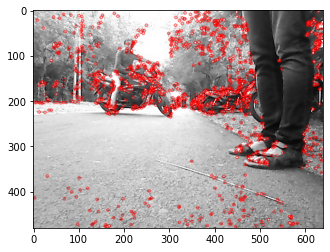

In [17]:
img = cv.imread(dataset_location +'/'+ L[0],cv.IMREAD_GRAYSCALE)
# Initiate FAST object with default values
fast = cv.FastFeatureDetector_create()
fast.setThreshold(75)
# find and draw the keypoints
kp = fast.detect(img,None)
img2 = cv.drawKeypoints(img, kp, None, color=(255,0,0))
# Print all default params
print( "Threshold: {}".format(fast.getThreshold()) )
print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
print( "neighborhood: {}".format(fast.getType()) )
print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp)) )
cv.imwrite('fast_true.png',img2)
# Disable nonmaxSuppression
fast.setNonmaxSuppression(0)
kp = fast.detect(img,None)
print( "Total Keypoints without nonmaxSuppression: {}".format(len(kp)) )
img3 = cv.drawKeypoints(img, kp, None, color=(255,0,0))
cv.imwrite('fast_false.png',img3)
plt.imshow(img2)

In [13]:
#for first two images
img1 = cv.imread(dataset_location +'/'+ L[0],cv.IMREAD_GRAYSCALE)
img2 = cv.imread(dataset_location +'/'+ L[1],cv.IMREAD_GRAYSCALE)
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
#matching images using sift
matches = bf.knnMatch(des1,des2,k=2)
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

src_p = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_p=np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
pts1 = np.float32(src_p)
pts2 = np.float32(dst_p)

R = []
t = []
#F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
#F,mask = cv.findFundamentalMat(pts1, pts2,cv.FM_RANSAC ,0.4,0.9,mask=None)
#E = k.T@F@k
E, mask = cv.findEssentialMat(pts1,pts2,k,cv.RANSAC, prob = 0.999,threshold = 0.4,mask=None)

retval, R, t, mask = cv.recoverPose(E, pts1, pts2, k)
#print(R,t)

#set of translations and rotations
translations = []
translations.append(np.zeros((3,1)))
rotations = []
rotations.append(np.identity(3))
a = 0
t0 = translations[0]
r0 = rotations[0]

#storing previous imgs
framep1 = img1[:]
framep2 = img2[:]
Rp = R[:]
Tp = t[:]
t0 = translations[0]
r0 = rotations[0]
match = 100
count = 0

#for remaining images
while(a < len(L)-2):
    
    #taking current image and finding the feature and then finding the common features brtween first img used for triangulation and current frame 
    print(L[a])
    current_img = cv.imread(dataset_location +'/'+ L[a],cv.IMREAD_GRAYSCALE)
    kpi, desi = sift.detectAndCompute(current_img,None)
    matches = bf.knnMatch(des1,desi,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    #print(R,t)
    kp1i = [ kp1[m.queryIdx] for m in good ]
    des1i = np.array([des1[m.queryIdx] for m in good])
    pts1 = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    ptsi=np.float32([kpi[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    
    #finding common features between first two t frame
    matches = bf.knnMatch(des1i,des2,k=2)
    cloud_matches = []
    for m,n in matches:
        if m.distance < n.distance:
            cloud_matches.append(m)

    pts1 = np.float32([ kp1i[m.queryIdx].pt for m in cloud_matches ]).reshape(-1,1,2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in cloud_matches]).reshape(-1,1,2)
    
    point_cloud = point3D(k,R,t,pts1,pts2)
    #print(len(pts2),len(pts1),len(ptsi),len(point_cloud))
    minidx = min(len(pts2),len(pts1),len(ptsi),len(point_cloud))
    ptsi = ptsi[:minidx,:,:]
    #print(len(pts2),len(pts1),len(ptsi),len(point_cloud))
    #match = threshold for pnp i.e it inliers of previous frame are greater than this threshold we will use pnp directly
    if match > 35:
        retval, rvec, tvec, inliers = cv.solvePnPRansac(point_cloud,ptsi, k, (0.1,0.1,0.1,0.1),useExtrinsicGuess = False ,iterationsCount = 100,reprojectionError = 5.0,confidence = 0.80,)
        print(tvec,len(inliers))
        #print(retval)
        match = len(inliers)
        translations.append(t0 + r0@tvec)
        #print(len(translations))
        Ri = cv.Rodrigues(rvec)
        Rt = Ri[0]
        rotations.append(r0@Rt)
        framep1 = framep2[:]
        framep2 = current_img[:]
        Rp = rotations[a-1]@rotations[a-2].T
        Tp = translations[a-1] - translations[a-2]
        #print(Tp)
        count = 0
     
    #else will trigulated point cloud from previous two imgs
    else:
        img1 = framep1[:]
        img2 = framep2[:]
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)
        R = Rp[:]
        t = Tp[:]
        #print(len(rotations))
        r0 = rotations[a-2]
        t0 = translations[a-2]
        #print(translations)
        #print(t0,a)
        a = a-1
        match = 100
        count = count + 1
        if count >3:
            break
            
    
    a = a+1
    
x0 = []
y0 = []
go = []
g1 = []
for i in range(len(L)-2):
    y0.append(-1*translations[i][2])
    x0.append(-1*translations[i][0])
    go.append(gx[i])
    g1.append(gz[i])
    
fig,axes = plt.subplots()

axes.plot(x0, y0,label = 'scale using dist ratio')
axes.plot(gx, gz,color = 'red',label = 'ground_truth')
axes.legend()

plt.show()

0.png
[[-0.4495233 ]
 [ 0.0510927 ]
 [ 1.38558767]] 152
1.png
[[0.62499993]
 [1.42045916]
 [5.12552617]] 114
10.png
[[  43.87372221]
 [  12.73534194]
 [-276.39235677]] 15
100.png
100.png
[[ 0.24744255]
 [ 0.01605517]
 [-0.47874331]] 17
101.png
101.png
[[-21.03353476]
 [  1.03867719]
 [ 48.94548145]] 17
102.png
102.png
[[  77.78319016]
 [ -21.89856649]
 [-130.89831416]] 44
103.png
[[ 140.46551939]
 [  62.34205018]
 [-390.66846669]] 24
104.png
104.png
[[-15.2665832 ]
 [  4.36614859]
 [ 51.97302424]] 59
105.png
[[-16.89957307]
 [  2.19737921]
 [ 52.92149406]] 36
106.png
[[-9.22962674]
 [ 8.48347382]
 [50.87781219]] 36
107.png
[[-15.53761482]
 [  4.42086393]
 [ 49.54588606]] 37
108.png
[[-18.33294   ]
 [  1.77397344]
 [ 49.7242026 ]] 68
109.png
[[-21.5444087 ]
 [  0.8041583 ]
 [ 46.79663393]] 62
11.png
[[-1.53518702e+01]
 [-1.26088919e-02]
 [ 5.47250456e+01]] 19
110.png
110.png


TypeError: object of type 'NoneType' has no len()

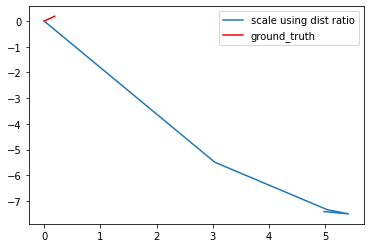